In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger et préparer les données
df = pd.read_csv("ndvi_grouped_smoothed_fes_meknes.csv")
df['date'] = pd.to_datetime(df['date'])
df_ndvi = df[['date', 'NDVI']].set_index('date').sort_index()

# Agréger par semaine et gérer les valeurs manquantes
df_weekly = df_ndvi.resample('W').mean().interpolate(method='linear')

--- Statistiques Descriptives ---
             NDVI
count  363.000000
mean     0.116024
std      0.032846
min      0.069456
25%      0.094798
50%      0.107344
75%      0.128647
max      0.253773


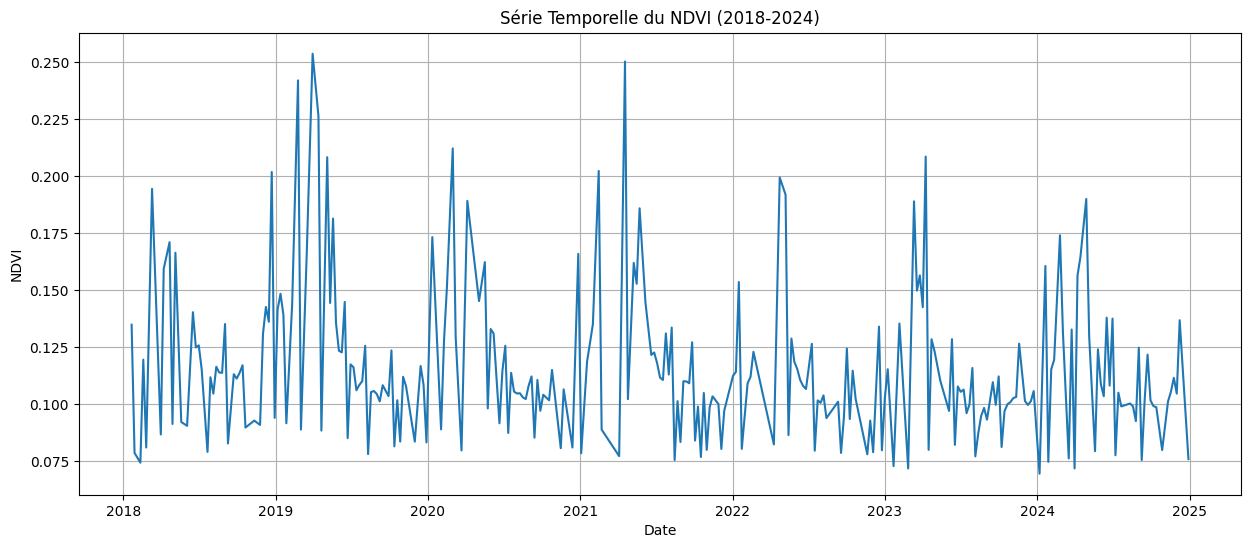

In [3]:
# Statistiques descriptives
print("--- Statistiques Descriptives ---")
print(df_weekly.describe())

# Visualisation de la série temporelle
plt.figure(figsize=(15, 6))
plt.plot(df_weekly.index, df_weekly['NDVI'], label='NDVI moyen hebdomadaire')
plt.title('Série Temporelle du NDVI (2018-2024)')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller, kpss

# Test Augmented Dickey-Fuller (ADF)
# Hypothèse nulle (H0): La série est non-stationnaire.
adf_result = adfuller(df_weekly['NDVI'])
print(f'--- Test ADF ---')
print(f'Statistique ADF: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
if adf_result[1] > 0.05:
    print("Conclusion : La série est probablement non-stationnaire (on ne rejette pas H0).")
else:
    print("Conclusion : La série est probablement stationnaire (on rejette H0).")

# Test KPSS
# Hypothèse nulle (H0): La série est stationnaire.
kpss_result = kpss(df_weekly['NDVI'], regression='c')
print(f'\n--- Test KPSS ---')
print(f'Statistique KPSS: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
if kpss_result[1] < 0.05:
    print("Conclusion : La série est probablement non-stationnaire (on rejette H0).")
else:
    print("Conclusion : La série est probablement stationnaire (on ne rejette pas H0).")

--- Test ADF ---
Statistique ADF: -4.271184645029002
p-value: 0.0004981150101805129
Conclusion : La série est probablement stationnaire (on rejette H0).

--- Test KPSS ---
Statistique KPSS: 0.4897862976074808
p-value: 0.04396705008840522
Conclusion : La série est probablement non-stationnaire (on rejette H0).


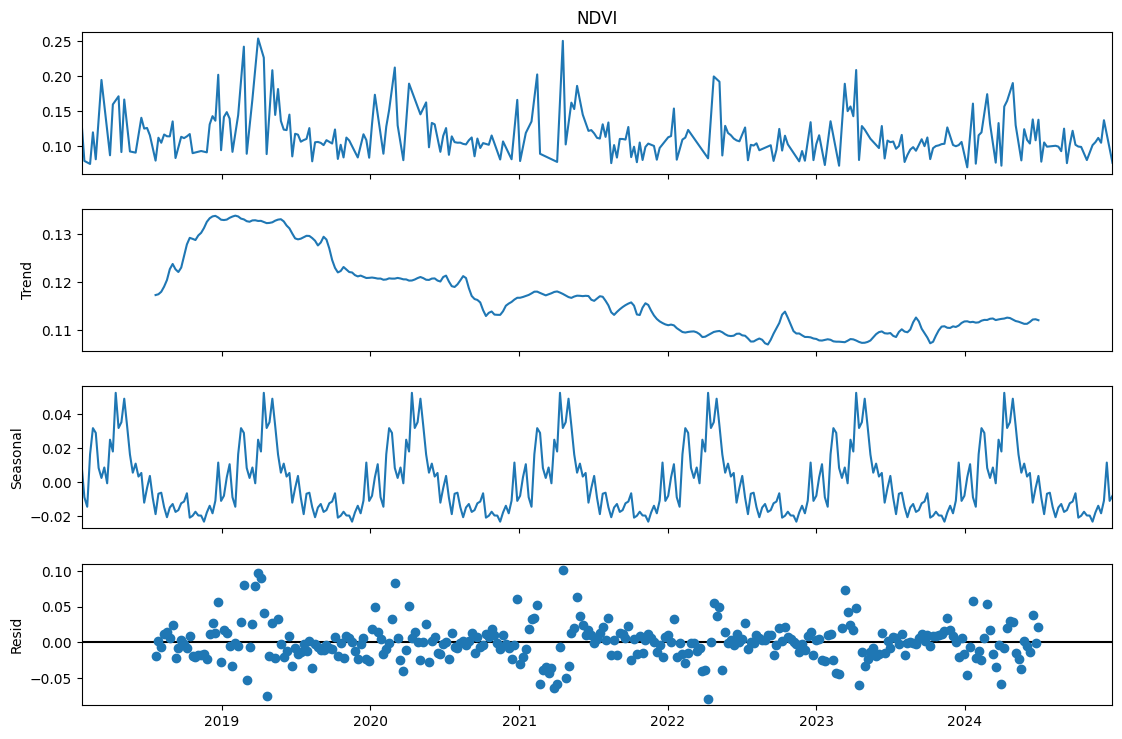

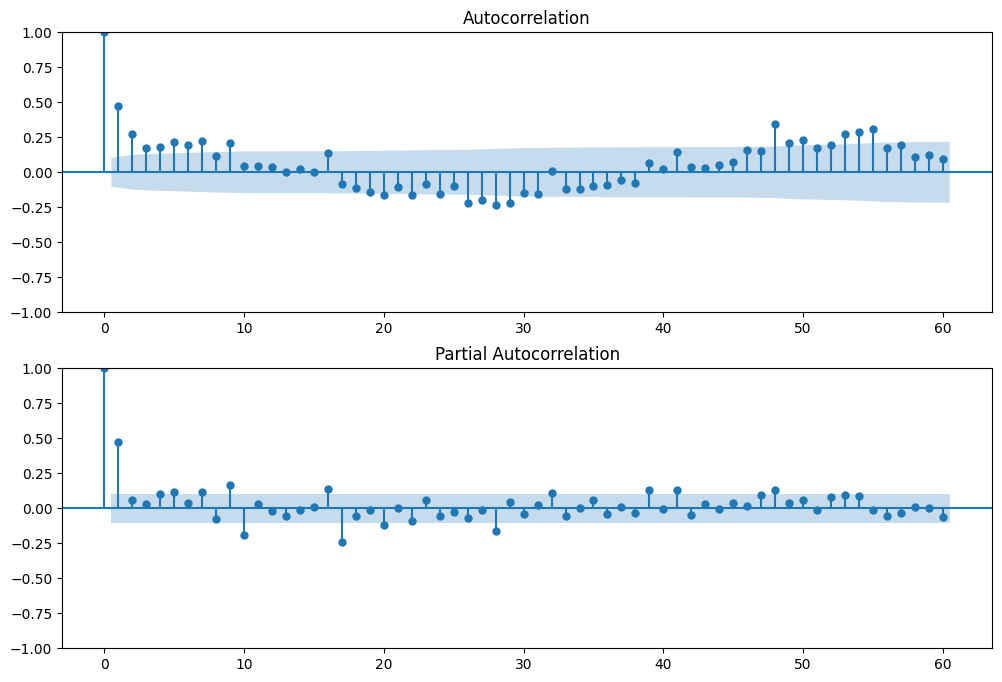

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Décomposition de la série
decomposition = seasonal_decompose(df_weekly['NDVI'], model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# Graphiques ACF et PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_weekly['NDVI'], ax=ax1, lags=60)
plot_pacf(df_weekly['NDVI'], ax=ax2, lags=60)
plt.show()

In [6]:
!pip install pandas matplotlib statsmodels pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.4 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from warnings import filterwarnings

filterwarnings("ignore") # Ignorer les avertissements pour un output plus propre

# --- ÉTAPE 1: PRÉTRAITEMENT DES DONNÉES ---
print("--- ÉTAPE 1: PRÉTRAITEMENT ---")
try:
    df = pd.read_csv("ndvi_grouped_smoothed_fes_meknes.csv")
    print("✅ Fichier chargé.")
except FileNotFoundError:
    print("❌ ERREUR : Le fichier 'ndvi_grouped_smoothed_fes_meknes.csv' est introuvable.")
    exit()

df['date'] = pd.to_datetime(df['date'])
df_ndvi = df[['date', 'NDVI']].set_index('date').sort_index()
df_weekly = df_ndvi.resample('W').mean().interpolate(method='linear')
print("✅ Données prétraitées et agrégées par semaine.")


# --- ÉTAPE 2: RECHERCHE PAR GRILLE (GRID SEARCH) DES MEILLEURS PARAMÈTRES ---
print("\n--- ÉTAPE 2: RECHERCHE DES MEILLEURS PARAMÈTRES (cela peut prendre un moment)... ---")

# Définir les plages de paramètres à tester
p = d = q = range(0, 2) # p, d, q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))] # P, D, Q, m=52

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Boucle pour tester les combinaisons
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = sm.tsa.SARIMAX(df_weekly['NDVI'],
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            results = temp_model.fit(disp=False)

            # Si le score AIC est meilleur, on garde les paramètres
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print(f"\n✅ Meilleurs paramètres trouvés : SARIMA{best_pdq}{best_seasonal_pdq} avec un AIC de {best_aic:.2f}")


# --- ÉTAPE 3: ENTRAÎNEMENT DU MODÈLE FINAL ---
print("\n--- ÉTAPE 3: ENTRAÎNEMENT DU MODÈLE FINAL ---")
final_model = sm.tsa.SARIMAX(df_weekly['NDVI'],
                             order=best_pdq,
                             seasonal_order=best_seasonal_pdq).fit(disp=False)
print("✅ Modèle final entraîné.")


--- ÉTAPE 1: PRÉTRAITEMENT ---
✅ Fichier chargé.
✅ Données prétraitées et agrégées par semaine.

--- ÉTAPE 2: RECHERCHE DES MEILLEURS PARAMÈTRES (cela peut prendre un moment)... ---

✅ Meilleurs paramètres trouvés : SARIMA(1, 1, 1)(0, 0, 0, 52) avec un AIC de -1519.25

--- ÉTAPE 3: ENTRAÎNEMENT DU MODÈLE FINAL ---
✅ Modèle final entraîné.


In [10]:

# Sauvegarder le modèle entraîné
nom_du_fichier_modele = 'mon_modele_sarima.joblib'
joblib.dump(results, nom_du_fichier_modele)
print(f"✅ Modèle sauvegardé sous le nom : {nom_du_fichier_modele}")

✅ Modèle sauvegardé sous le nom : mon_modele_sarima.joblib


In [11]:
import joblib
import pandas as pd # Nécessaire pour les dates futures

# Assurez-vous d'importer (uploader) votre fichier modèle sauvegardé
nom_du_fichier_modele = 'mon_modele_sarima.joblib'

# Charger le modèle à partir du fichier
modele_charge = joblib.load(nom_du_fichier_modele)

print("✅ Modèle SARIMA chargé avec succès depuis le disque.")


✅ Modèle SARIMA chargé avec succès depuis le disque.



--- ÉTAPE 4: PRÉDICTIONS FUTURES ---
✅ Prédictions pour l'année suivante générées.


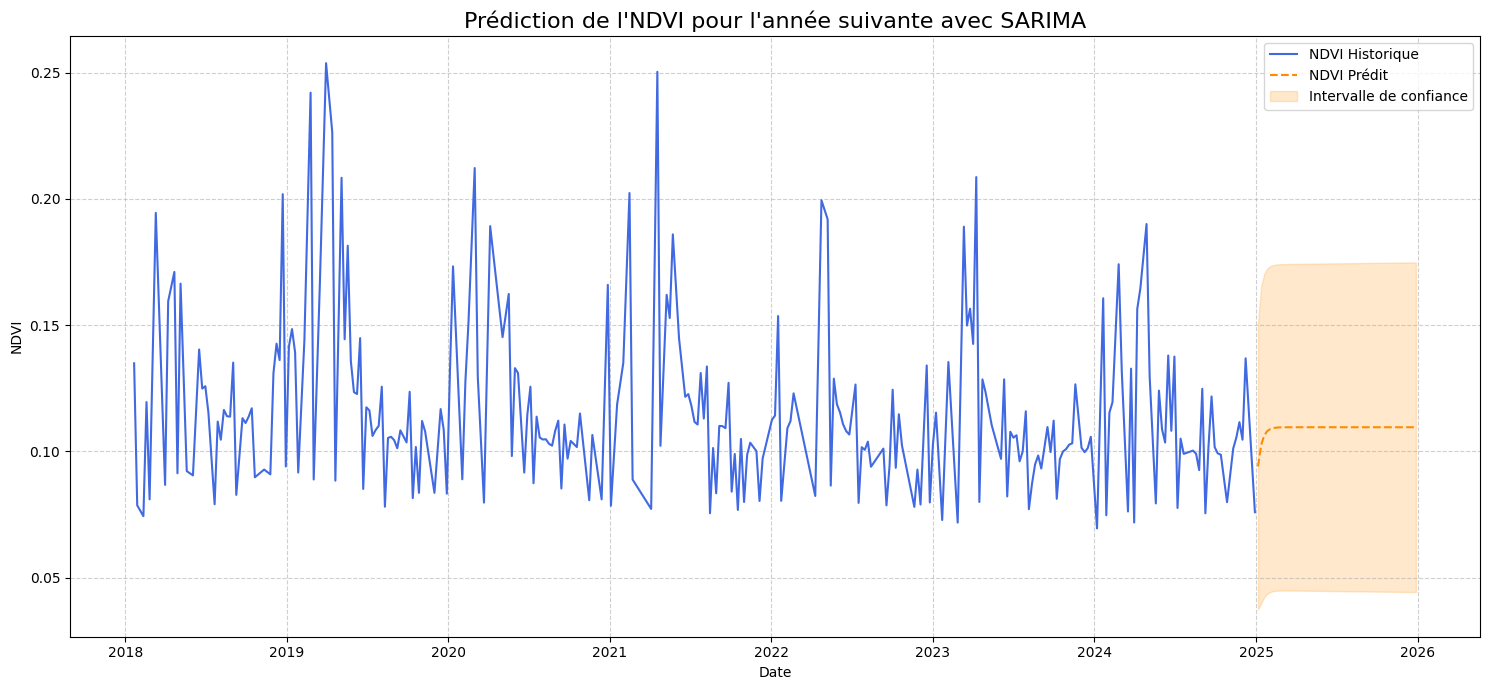

In [8]:


# --- ÉTAPE 4: PRÉDICTION POUR L'ANNÉE SUIVANTE ---
print("\n--- ÉTAPE 4: PRÉDICTIONS FUTURES ---")
n_periods = 52
forecast_result = final_model.get_forecast(steps=n_periods)
forecast_df = forecast_result.summary_frame()
print("✅ Prédictions pour l'année suivante générées.")


# --- ÉTAPE 5: VISUALISATION FINALE ---
plt.figure(figsize=(15, 7))
plt.plot(df_weekly.index, df_weekly['NDVI'], label='NDVI Historique', color='royalblue')
plt.plot(forecast_df.index, forecast_df['mean'], label='NDVI Prédit', color='darkorange', linestyle='--')
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='darkorange', alpha=0.2, label='Intervalle de confiance')
plt.title("Prédiction de l'NDVI pour l'année suivante avec SARIMA", fontsize=16)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("prediction_ndvi_sarima_gridsearch.png")
plt.show()